In [1]:
import os
import json
import numpy as np
import pandas as pd
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import nibabel as nib
import matplotlib.pyplot as plt
from dataset import CarotidDataset
from unet import UNet, UNetWrapper
from utils import DiceLoss
from torchvision import transforms

from torchvision.transforms.functional import to_pil_image

import matplotlib.pyplot as plt

In [2]:
batch_size = 1
data = CarotidDataset()
dataloader = torch.utils.data.DataLoader(
    data, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=1)
net = UNetWrapper(in_channels=3, n_classes=1, depth=5, batch_norm=True, padding=True, up_mode='upsample')
net.load_state_dict(torch.load('models/unet.pth'))
net.eval()
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=1)

In [3]:
inputs, labels = next(iter(dataloader))

In [4]:
preds = net(inputs)
preds.shape

torch.Size([1, 1, 256, 256])

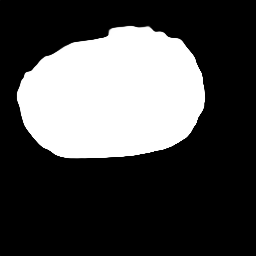

In [5]:
transforms.functional.to_pil_image(preds[0])

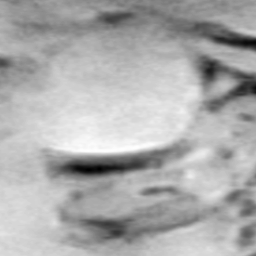

In [6]:
transforms.functional.to_pil_image(inputs[0][2])

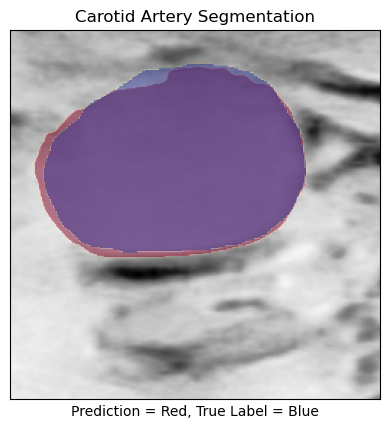

In [7]:
def plot_pred(preds, inputs, labels=None):
    pred_out = preds[0][0].detach().numpy()
    background = inputs[0][2].detach().numpy()
    plt.imshow(background, cmap='Greys', alpha=1)
    plt.imshow(pred_out, 
            cmap='YlOrRd',
            alpha=pred_out*.5)
    if labels != None:
        labels = labels > 0
        labels = labels.type(torch.int8)
        label_out = labels[0][0].numpy()
        plt.imshow(label_out, 
           cmap='RdYlBu', 
           alpha=label_out*.5)
        plt.xlabel('Prediction = Red, True Label = Blue',)
    else:
        plt.xlabel('Prediction = Red',)
    plt.title('Carotid Artery Segmentation')
    plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    
    plt.show()

plot_pred(preds, inputs, labels)